In [1]:
!pip install -q ultralytics tqdm lxml matplotlib albumentations torchvision

import os
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
import torchvision
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class Config:
    VOC_YEAR = "2012"
    VOC_ROOT = "./VOCdevkit/VOC2012"
    OUTPUT_ROOT = "./dataset"
    MODEL_TYPE = "yolov8n.pt"
    CLASSES = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]

Config.TRAINING_CONFIG = Config.TRAINING_CONFIG = {
    'data': "voc.yaml",
    'batch': 16,
    'imgsz': 640,
    'lr0': 0.001,
    'lrf': 0.02,
    'optimizer': "SGD",
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'epochs': 250,
    'augment': True,
    'verbose': True,
    'workers': 4,
    'patience': 500,
    'save': True
}



In [3]:
def prepare_dataset():
    torchvision.datasets.VOCDetection(root=".", year=Config.VOC_YEAR, image_set="train", download=True)
    for dir_path in [f"{Config.OUTPUT_ROOT}/images/train", f"{Config.OUTPUT_ROOT}/images/val",
                     f"{Config.OUTPUT_ROOT}/labels/train", f"{Config.OUTPUT_ROOT}/labels/val"]:
        os.makedirs(dir_path, exist_ok=True)

prepare_dataset()


100%|██████████| 2.00G/2.00G [02:16<00:00, 14.7MB/s]


In [4]:
def convert_annotation(xml_path, txt_path, img_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    with open(txt_path, 'w') as f:
        for obj in root.findall('object'):
            cls_name = obj.find('name').text
            if cls_name not in Config.CLASSES:
                continue
            cls_id = Config.CLASSES.index(cls_name)
            bbox = obj.find('bndbox')
            coords = [int(bbox.find(dim).text) for dim in ['xmin', 'ymin', 'xmax', 'ymax']]
            x_center = (coords[0] + coords[2]) / 2 / img_size[0]
            y_center = (coords[1] + coords[3]) / 2 / img_size[1]
            width = (coords[2] - coords[0]) / img_size[0]
            height = (coords[3] - coords[1]) / img_size[1]
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [5]:
from tqdm import tqdm
def process_data_split(split_name, limit=None):
    split_file = os.path.join(Config.VOC_ROOT, 'ImageSets/Main', f'{split_name}.txt')
    with open(split_file, 'r') as f:
        image_ids = [line.strip() for line in f.readlines()]
    if limit:
        image_ids = image_ids[:limit]
    for img_id in tqdm(image_ids, desc=f"Processing {split_name}"):
        img_src = os.path.join(Config.VOC_ROOT, 'JPEGImages', f'{img_id}.jpg')
        xml_src = os.path.join(Config.VOC_ROOT, 'Annotations', f'{img_id}.xml')
        img_dest = os.path.join(Config.OUTPUT_ROOT, f'images/{split_name}', f'{img_id}.jpg')
        label_dest = os.path.join(Config.OUTPUT_ROOT, f'labels/{split_name}', f'{img_id}.txt')
        shutil.copy(img_src, img_dest)
        with Image.open(img_src) as img:
            convert_annotation(xml_src, label_dest, img.size)

process_data_split("train", limit=500)
process_data_split("val", limit=100)


Processing val: 100%|██████████| 100/100 [00:00<00:00, 1670.75it/s]


In [6]:
def create_yaml_config():
    yaml_content = f"""\
path: {Config.OUTPUT_ROOT}
train: images/train
val: images/val
names: {dict(enumerate(Config.CLASSES))}
"""
    with open("voc.yaml", "w") as f:
        f.write(yaml_content)

create_yaml_config()


In [7]:
def train_model():
    model = YOLO(Config.MODEL_TYPE)
    device = 0 if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {device}")
    Config.TRAINING_CONFIG['device'] = device
    results = model.train(**Config.TRAINING_CONFIG)
    return results

results = train_model()


100%|██████████| 6.25M/6.25M [00:00<00:00, 67.3MB/s]


Training on device: 0
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.02, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=500, perspective=0.0, plots=True, pose=12.0, pretrained=

100%|██████████| 755k/755k [00:00<00:00, 30.5MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

 22        [15, 18, 21]  1    755212  ultralytics.nn.modules.head.Detect           [20, [64, 128, 256]]          
Model summary: 129 layers, 3,014,748 parameters, 3,014,732 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1956.7±859.3 MB/s, size: 104.5 KB)


train: Scanning /content/dataset/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 1911.01it/s]

train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1008.0±872.3 MB/s, size: 87.4 KB)


val: Scanning /content/dataset/labels/val... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 2072.12it/s]


val: New cache created: /content/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      2.19G     0.9446          4      1.202         15        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        100        239   0.000302     0.0402     0.0151     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      2.68G      0.926      3.609      1.226         17        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        100        239    0.00556     0.0724     0.0369     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250       2.7G     0.9632       3.27      1.235         33        640: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        100        239      0.991     0.0299     0.0903     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      2.71G     0.9379      2.889      1.198         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


                   all        100        239      0.993     0.0387     0.0847     0.0604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      2.72G     0.9113      2.719      1.196         26        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        239      0.994     0.0391      0.149      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      2.73G      0.945      2.558      1.192         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        100        239       0.84     0.0829      0.202      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      2.74G       0.94      2.484      1.199         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        239      0.796      0.121      0.248      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      2.75G     0.9243      2.381      1.204         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        100        239      0.645      0.233      0.284      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      2.76G     0.9028      2.237      1.188         17        640: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        100        239      0.709      0.234      0.345      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      2.78G     0.8711      2.123      1.181         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239      0.758      0.244      0.392      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      2.79G      0.913      2.076      1.179         17        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        100        239      0.737      0.335      0.433      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250       2.8G     0.8745      1.891      1.175         29        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        100        239      0.719      0.417      0.465      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      2.81G     0.8933      1.849       1.18         37        640: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        100        239      0.797      0.374      0.467       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      2.82G     0.9196      1.801      1.176         27        640: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        100        239       0.79      0.343      0.474       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      2.83G     0.9077      1.747       1.18         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        100        239      0.644      0.399      0.508      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      2.84G     0.8875      1.702      1.183         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        100        239      0.699      0.429      0.533      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      2.86G     0.8607      1.612      1.161         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        239      0.737      0.422      0.558      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      2.87G      0.853      1.641      1.165         28        640: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        100        239      0.774      0.406      0.552      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      2.88G     0.8729      1.543      1.168         43        640: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        100        239      0.745      0.425      0.534      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      2.89G     0.8655      1.522      1.144         22        640: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        100        239      0.653      0.466      0.556      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250       2.9G     0.8579       1.53      1.148         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        100        239      0.573       0.55      0.558      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      2.91G      0.848       1.48      1.143         32        640: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        100        239      0.587      0.552      0.564      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      2.93G     0.8323      1.468      1.137         23        640: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        100        239      0.648      0.585      0.593       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      2.94G     0.8371      1.431      1.133         34        640: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        100        239      0.674      0.559      0.595      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      2.95G     0.8393      1.409      1.145         29        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        100        239       0.68      0.571      0.601      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      2.96G      0.825      1.385      1.129         18        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239      0.721      0.547      0.611      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      2.97G     0.8304      1.426      1.133         36        640: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        100        239       0.68      0.539      0.607      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      2.98G     0.8066      1.385      1.128         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        239       0.61      0.601      0.607      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      2.99G     0.8191      1.376       1.13         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        100        239      0.612      0.609       0.62      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250         3G     0.7888      1.338       1.13         37        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        100        239      0.668      0.603      0.622      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      3.02G     0.8199      1.372      1.132         56        640: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        100        239      0.776      0.492      0.619       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      3.03G     0.8015      1.328      1.118         16        640: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


                   all        100        239      0.758      0.526      0.633      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      3.04G     0.7776      1.309      1.109         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        100        239      0.677      0.591      0.624      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      3.05G     0.7832      1.315      1.112         47        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        100        239      0.659      0.593      0.614      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      3.06G     0.7755      1.293      1.106         32        640: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        100        239      0.742      0.569       0.65      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      3.07G     0.7656      1.301      1.106         18        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        100        239      0.671      0.603      0.667      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      3.09G     0.7788      1.276      1.101         20        640: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239      0.822      0.509      0.645      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250       3.1G      0.783      1.232      1.104         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        100        239      0.786      0.549      0.675      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      3.11G     0.7708      1.263      1.097         30        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        100        239      0.794      0.548      0.668      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      3.12G     0.7703      1.234        1.1         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        100        239      0.811      0.547      0.681      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      3.13G     0.7388      1.244      1.083         33        640: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


                   all        100        239       0.66      0.592      0.649      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      3.14G     0.7542      1.238      1.098         23        640: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        100        239       0.73      0.561      0.643      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      3.16G      0.769      1.193      1.086         18        640: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        100        239      0.786      0.562      0.662       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      3.16G     0.7555      1.199      1.072         35        640: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        239      0.751      0.562      0.657      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      3.18G     0.7359      1.212      1.088         15        640: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        100        239       0.77      0.541      0.634      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      3.19G     0.7549      1.215      1.086         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        100        239      0.619      0.598       0.66      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250       3.2G     0.7307      1.151      1.076         20        640: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        100        239      0.717      0.556      0.632      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      3.21G     0.7341      1.145      1.069         42        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        100        239      0.737       0.53      0.626      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      3.22G      0.747      1.146      1.087         20        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        100        239      0.709      0.604      0.656      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      3.23G     0.7437       1.16      1.077         36        640: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        100        239      0.651      0.623      0.657      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      3.25G     0.7554      1.175      1.092         15        640: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        239      0.746      0.561      0.653      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      3.26G     0.7544      1.149      1.086         20        640: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        100        239      0.676      0.614      0.657      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      3.27G      0.724      1.144      1.068         13        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        100        239      0.606      0.684      0.657      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      3.28G     0.7289      1.144       1.07         28        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        100        239      0.608      0.658       0.66      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      3.29G     0.7248      1.153      1.068         45        640: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        100        239      0.755      0.555      0.664      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250       3.3G     0.7334      1.147      1.083         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239      0.667      0.609      0.661      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      3.31G     0.7125      1.093      1.063         36        640: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        239      0.735       0.57      0.636      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      3.33G     0.7266      1.143      1.083         31        640: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        239      0.749      0.575      0.651      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      3.34G     0.7118      1.136      1.075         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        100        239      0.748      0.573      0.649      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      3.35G     0.7253      1.131      1.071         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


                   all        100        239      0.738      0.576      0.658      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      3.36G     0.7057      1.088      1.063         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        100        239      0.679      0.612      0.659      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      3.37G     0.7028      1.067      1.062         15        640: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        100        239      0.661      0.612      0.667        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      3.38G     0.7236      1.089      1.073         13        640: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

                   all        100        239      0.614      0.625      0.657      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      3.39G     0.7035      1.085      1.059         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        100        239      0.706      0.564      0.652      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250       3.4G     0.6989       1.09      1.051         33        640: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        100        239      0.778      0.535      0.615      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      3.42G     0.7196      1.105       1.07         18        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        100        239      0.776      0.599      0.656      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      3.43G     0.7025       1.05      1.048         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        100        239      0.701      0.633      0.644      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      3.44G     0.7062      1.095      1.072         12        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        100        239      0.672      0.626      0.643      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      3.45G     0.6984      1.049      1.046         25        640: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        100        239      0.705      0.564      0.631      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      3.46G     0.6907      1.037      1.054         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        100        239      0.728       0.53      0.618      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      3.47G     0.7034      1.048       1.04         29        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        100        239      0.679      0.586      0.614      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      3.48G     0.6905       1.04      1.056         17        640: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        100        239      0.597      0.622      0.643      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250       3.5G      0.683      1.053      1.047         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


                   all        100        239       0.69      0.588      0.625      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      3.51G     0.6771      1.047      1.055         32        640: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        239       0.67      0.556      0.611      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      3.52G      0.685      1.052      1.044         27        640: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.682      0.561      0.613      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      3.53G     0.6928      1.024       1.05         30        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        100        239      0.636      0.602      0.602      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      3.54G     0.6893      1.033      1.042         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239       0.69      0.572      0.622      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      3.55G     0.7112       1.03       1.04         32        640: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


                   all        100        239      0.722      0.579      0.603      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      3.56G      0.684      1.024      1.046         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        239      0.648      0.623      0.627      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      3.58G     0.6931      1.043      1.055         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239      0.702      0.571      0.624      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      3.59G     0.6815       1.04      1.051         26        640: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        100        239      0.704      0.566      0.639      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250       3.6G     0.6544     0.9954      1.039         22        640: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


                   all        100        239      0.735      0.548       0.64      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      3.61G     0.6823      1.006      1.036         31        640: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all        100        239      0.746      0.521      0.638      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      3.62G     0.6578      1.029      1.035         12        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        100        239      0.707      0.558      0.624      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      3.63G     0.6769      1.004       1.04         30        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all        100        239      0.704      0.593       0.66      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      3.64G     0.6529      1.025      1.035         49        640: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        100        239      0.723      0.568      0.654      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      3.66G     0.6638     0.9905      1.043         44        640: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        100        239      0.716      0.574      0.643      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      3.67G     0.6757      1.007      1.058         13        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        100        239      0.693      0.566      0.624      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      3.68G     0.6505     0.9965      1.038         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        100        239      0.684       0.57      0.635      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      3.69G     0.6725      1.003       1.04         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        100        239      0.714      0.563      0.634      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250       3.7G     0.6631     0.9642      1.034         23        640: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        100        239      0.683      0.572      0.629      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      3.71G      0.659     0.9829      1.042         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239      0.775      0.531      0.643      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      3.72G     0.6624     0.9782      1.039         50        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        100        239      0.703      0.576      0.646      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      3.74G     0.6661      1.001       1.03         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        100        239      0.725       0.54      0.621      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      3.75G     0.6441     0.9949      1.028         15        640: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        100        239      0.735      0.531       0.61      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      3.76G     0.6675     0.9645      1.027         37        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        100        239      0.735      0.535      0.611      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      3.77G     0.6451     0.9695      1.025         28        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        239      0.755      0.523      0.619      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      3.78G     0.6642     0.9724      1.027         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        100        239      0.728      0.533      0.622      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      3.79G     0.6486     0.9682      1.019         35        640: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        100        239      0.645      0.575       0.62      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250       3.8G     0.6594     0.9642      1.021         20        640: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        100        239      0.657      0.556      0.621      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      3.82G     0.6325     0.9575      1.029         15        640: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        100        239      0.691      0.552      0.617      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      3.83G     0.6496     0.9605      1.024         35        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        100        239      0.692      0.569      0.618      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      3.84G      0.653     0.9474      1.029         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        100        239      0.678      0.587      0.647      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      3.85G     0.6515     0.9495      1.025         40        640: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


                   all        100        239      0.687      0.586      0.649      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      3.86G     0.6551     0.9813      1.028         11        640: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        100        239      0.749      0.528       0.63      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      3.87G     0.6441     0.9707      1.031         51        640: 100%|██████████| 32/32 [00:10<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        100        239      0.694      0.585      0.638      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      3.88G      0.622     0.9686      1.019         25        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        239      0.714      0.589      0.655      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250       3.9G     0.6441     0.9511      1.025         31        640: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        100        239      0.577      0.643      0.649      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      3.91G     0.6228     0.9325      1.018         10        640: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        239      0.675      0.576      0.665      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      3.92G     0.6349     0.9505      1.027         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        100        239      0.726       0.56      0.679      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      3.93G     0.6224     0.9688      1.028         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        100        239      0.671      0.543      0.645      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      3.94G     0.6454     0.9541      1.027         61        640: 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

                   all        100        239      0.617      0.615      0.643      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      3.95G     0.6451     0.9341      1.026         27        640: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        100        239      0.677      0.585      0.644      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      3.96G     0.6312      0.935      1.022         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        100        239      0.702      0.576       0.65      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      3.98G     0.6452     0.9335      1.027         28        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        100        239      0.632      0.622      0.642       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      3.99G     0.6414     0.9583      1.029         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        100        239      0.588      0.619      0.648      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250         4G     0.6378     0.9274      1.024         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239      0.632      0.602      0.641      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      4.01G     0.6318     0.9406      1.022         30        640: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


                   all        100        239      0.622      0.611      0.667       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      4.03G     0.6276     0.9075      1.012         13        640: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        100        239      0.691      0.562      0.658      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      4.04G     0.6293     0.9537      1.021         17        640: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        100        239      0.629      0.587      0.652      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      4.04G     0.6099     0.9044     0.9992         20        640: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.644      0.569      0.628      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      4.05G     0.6146     0.9171      1.013         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        100        239      0.708      0.551      0.634      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      4.07G     0.6219     0.9025      1.017         16        640: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


                   all        100        239      0.735      0.556      0.636      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      4.08G     0.6321     0.9142      1.014         28        640: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        239      0.772      0.547      0.639      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      4.09G     0.6325     0.9561      1.026         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        239      0.734      0.557      0.644      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250       4.1G     0.6167     0.9049      1.015         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all        100        239      0.623      0.597      0.652      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      4.11G     0.6391     0.9079      1.009         49        640: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        239      0.778      0.564      0.667      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      4.12G     0.6148     0.8998      1.011         29        640: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        100        239      0.686      0.623      0.691      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      4.14G     0.6465     0.9375      1.025         22        640: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        239      0.714      0.589      0.693      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      4.15G     0.6271       0.93      1.015         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239       0.71      0.609      0.686      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      4.16G     0.6217     0.9011      1.014         34        640: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        239      0.744      0.584      0.675      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      4.17G     0.6268     0.9062      1.014         26        640: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        100        239       0.75      0.568      0.656      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      4.18G     0.6175     0.9103       1.01         29        640: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        100        239       0.75      0.572      0.676      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      4.19G      0.614     0.9069      1.016         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        100        239      0.667      0.589      0.671      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      4.21G     0.6267     0.9046      1.021         28        640: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        100        239      0.742      0.573      0.674      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      4.22G     0.6209     0.9218      1.015         17        640: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        100        239      0.686       0.61       0.68      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      4.23G     0.6128     0.9056      1.021         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


                   all        100        239      0.693      0.611      0.675       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      4.24G     0.6033     0.8935      1.002         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.732       0.59      0.674      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      4.25G     0.6031     0.8907      1.013         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        239      0.737      0.587      0.664      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      4.27G     0.6032     0.8702      1.001         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        239      0.754      0.577      0.658      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      4.27G     0.5753     0.8813     0.9977         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all        100        239      0.741      0.582      0.645      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      4.28G     0.6047     0.8721      1.001         23        640: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239      0.712      0.588      0.655      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250       4.3G     0.5933     0.8728      1.004         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        239      0.663      0.589      0.651      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      4.31G     0.6167      0.892      1.004         15        640: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        100        239      0.712      0.553      0.652       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      4.32G     0.6035     0.9008      1.004         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        100        239      0.734      0.567      0.653      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      4.33G      0.598     0.8611     0.9997         27        640: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        100        239      0.767      0.563      0.655      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      4.34G     0.6054     0.8977      1.011         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        100        239      0.682      0.592      0.653      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      4.35G     0.5933     0.8641      1.006         51        640: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        100        239      0.734      0.575      0.649      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      4.36G      0.602     0.9084      1.014         28        640: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        100        239       0.71      0.585      0.652      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      4.38G     0.6091      0.879      1.005         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


                   all        100        239      0.737      0.583      0.671      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      4.39G     0.5875     0.8604     0.9923         44        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        100        239      0.722      0.583       0.66      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250       4.4G     0.5964     0.8812      1.006         20        640: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        239      0.623      0.604       0.65      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      4.41G     0.5707      0.877      1.004         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        100        239       0.74      0.532      0.653      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      4.42G     0.5981     0.8865          1         23        640: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        100        239      0.802       0.53      0.677      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      4.43G     0.5918     0.8379     0.9867         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        100        239      0.817      0.543      0.679      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      4.45G     0.5764     0.8451     0.9951         17        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        100        239      0.708      0.635      0.682      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      4.46G     0.6005     0.8808      1.003         16        640: 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        100        239      0.822      0.532      0.672      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      4.47G     0.5785     0.8523     0.9911         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        100        239      0.756      0.552      0.659      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      4.48G     0.5991     0.8604     0.9991         14        640: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        100        239      0.806      0.514      0.666      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      4.49G     0.6057      0.864      1.005         38        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239      0.763      0.527      0.654      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250       4.5G     0.5933     0.8639      0.995         17        640: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        100        239       0.72      0.546      0.651      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      4.51G     0.5926     0.8476     0.9908         32        640: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        239      0.731      0.541      0.656      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      4.52G     0.5623     0.8296     0.9856         52        640: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        100        239      0.687      0.564      0.661      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      4.54G     0.5932     0.8707     0.9931         14        640: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        100        239      0.609      0.618      0.648      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      4.55G      0.564     0.8604     0.9932         18        640: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        239      0.639      0.609      0.638       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      4.56G     0.5938     0.8522     0.9882         34        640: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        239      0.721      0.576      0.645      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      4.57G     0.5828      0.827     0.9862         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        239      0.717      0.571      0.641      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      4.58G     0.6081     0.8804       1.01         23        640: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        100        239      0.721      0.553      0.644      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      4.59G     0.5884     0.8571     0.9905         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        100        239      0.748      0.541      0.655      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250       4.6G      0.593     0.8466     0.9938         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        100        239      0.717      0.561      0.643      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      4.62G     0.5695     0.8451     0.9887         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        100        239      0.606      0.634      0.643      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      4.63G     0.5625     0.8405     0.9892         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        100        239      0.634      0.628      0.641      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      4.64G     0.5648     0.8299     0.9835         28        640: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        100        239      0.744      0.574      0.649      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      4.65G     0.5807     0.8535     0.9955         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        239       0.77       0.56      0.656      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      4.66G      0.578     0.8623     0.9959         14        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        100        239       0.75      0.554      0.654      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      4.67G     0.5947     0.8444      0.998         28        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        100        239      0.808      0.535      0.644      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      4.68G     0.5866      0.851     0.9948         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.795      0.549      0.658      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250       4.7G     0.5679     0.8119     0.9796         33        640: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        100        239      0.787      0.547      0.665      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      4.71G     0.5898     0.8694      1.003         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        239      0.604      0.626      0.666      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      4.72G     0.5878     0.8557      1.002         31        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        239      0.614       0.63      0.662      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      4.73G     0.5836     0.8247     0.9863         24        640: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        100        239      0.684      0.621      0.676      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      4.74G     0.5512     0.8259     0.9858         30        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


                   all        100        239      0.652      0.655      0.677      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      4.75G     0.5775     0.8334     0.9958         23        640: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        100        239      0.676      0.629      0.671      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      4.76G     0.5734     0.8538          1         24        640: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        100        239      0.672      0.623      0.658      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      4.78G     0.5656     0.8486     0.9912         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        100        239      0.668      0.612      0.659      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      4.79G     0.5856      0.842     0.9992         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        100        239      0.704      0.602      0.658      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250       4.8G     0.5795     0.8477          1         51        640: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        239      0.678      0.592      0.658      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      4.81G     0.5632     0.8217     0.9925         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        100        239        0.7      0.571      0.652      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      4.82G     0.5606     0.8351     0.9905         26        640: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        100        239       0.75      0.567      0.653      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      4.83G     0.5546     0.8175     0.9778         22        640: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        100        239      0.776      0.576      0.661      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      4.84G     0.5761     0.8472     0.9936         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        100        239      0.708      0.593      0.662       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      4.86G     0.5474     0.8396     0.9969         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        100        239      0.749      0.583      0.657      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      4.87G     0.5763     0.8428     0.9937         19        640: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        100        239      0.756      0.578      0.659      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      4.88G     0.5626     0.8414     0.9874         13        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        100        239      0.706      0.595      0.658      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      4.89G      0.555      0.825     0.9874         24        640: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        100        239      0.677      0.597      0.665      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250       4.9G     0.5718     0.8491          1         28        640: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        100        239      0.692      0.607      0.672      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      4.92G     0.5803     0.8161     0.9842         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        100        239      0.674      0.619      0.662      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      4.92G     0.5581     0.8151     0.9833         35        640: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        100        239      0.734      0.602      0.666      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      4.94G     0.5743     0.8263     0.9883         29        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        100        239      0.734      0.606      0.668      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      4.95G      0.557     0.8064     0.9869         18        640: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        100        239      0.755      0.581      0.669      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      4.96G     0.5446     0.8051     0.9686         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        100        239      0.748      0.579      0.676      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      4.97G     0.5654     0.8213     0.9889         15        640: 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        100        239      0.727      0.593      0.674       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      4.98G      0.544     0.7978     0.9746         25        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.775      0.587      0.679      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      4.99G     0.5646     0.8318      0.986         25        640: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        100        239      0.777      0.571      0.667      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250         5G     0.5623     0.8173     0.9853         27        640: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


                   all        100        239      0.782      0.582      0.679      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      5.02G     0.5498     0.8195     0.9911         27        640: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        100        239       0.76      0.582      0.673      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      5.03G     0.5575     0.8042     0.9806         34        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        239       0.74       0.58      0.658      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      5.04G     0.5718     0.8257     0.9793         36        640: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        100        239      0.735       0.59      0.678      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      5.05G      0.569     0.8089     0.9874         33        640: 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        100        239      0.747      0.579      0.676      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      5.06G     0.5645     0.8153      0.984         35        640: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        100        239      0.759      0.588      0.666      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      5.07G     0.5806      0.828     0.9888         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all        100        239      0.791      0.561      0.665       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      5.08G     0.5599     0.8149     0.9852         33        640: 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        100        239      0.778      0.562       0.67      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      5.09G     0.5501     0.8031       0.98         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        100        239      0.774      0.569      0.667      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      5.11G     0.5476     0.8138      0.982         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        100        239       0.77      0.566       0.67      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      5.12G     0.5437     0.8136     0.9747         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        100        239      0.713      0.592      0.662      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      5.13G     0.5656     0.8261     0.9794         34        640: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        100        239      0.763       0.56      0.665      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      5.14G     0.5476     0.8112     0.9794         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        100        239      0.714      0.588      0.677      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      5.15G     0.5535     0.8038     0.9777         38        640: 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        100        239      0.741      0.588      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      5.16G     0.5593     0.8183       0.99         37        640: 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        100        239      0.748      0.591      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      5.18G       0.55     0.7924     0.9767         23        640: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        100        239       0.71      0.598      0.665      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      5.19G     0.5385     0.7991     0.9836         34        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


                   all        100        239      0.769       0.58      0.662      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250       5.2G      0.537     0.7947     0.9786         27        640: 100%|██████████| 32/32 [00:10<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        100        239       0.76      0.589      0.668      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      5.21G     0.5395     0.7926     0.9718         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        100        239      0.747      0.586      0.672      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      5.22G     0.5564     0.8312     0.9909         18        640: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

                   all        100        239       0.72      0.586      0.669      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250      5.23G     0.5653     0.8209     0.9867         36        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        100        239       0.76      0.574       0.67      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      5.24G     0.5515      0.811     0.9812         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        100        239      0.757      0.586      0.668      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      5.25G     0.5475     0.8056     0.9754         38        640: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        100        239       0.76      0.582      0.665      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      5.27G     0.5481     0.7911     0.9774         24        640: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.775       0.58      0.673      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250      5.28G     0.5344     0.8007     0.9735         24        640: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        100        239      0.783      0.573      0.672      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      5.29G     0.5535      0.826      1.002         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


                   all        100        239      0.752       0.57      0.669      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250       5.3G     0.5568     0.7819     0.9705         40        640: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        239      0.701      0.601      0.667      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      5.32G     0.5567     0.8357     0.9948         18        640: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        239      0.721      0.594      0.672      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250      5.32G     0.5489     0.7997     0.9757         25        640: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        100        239      0.719      0.576      0.666      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      5.33G     0.5494     0.8024     0.9832         21        640: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        100        239       0.72      0.594      0.665      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      5.35G     0.5498      0.798     0.9756         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        100        239      0.738      0.594      0.664      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      5.36G      0.558     0.7939     0.9876         18        640: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239       0.74      0.568      0.665      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      5.37G     0.5503     0.8188     0.9839         24        640: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        239      0.747      0.578      0.664       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      5.38G     0.5528     0.8154     0.9808         19        640: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        239      0.702      0.602      0.666      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      5.39G     0.5493     0.7948     0.9715         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        100        239      0.727      0.585       0.67      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250       5.4G     0.5439      0.784     0.9731         51        640: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        239      0.751      0.576      0.663      0.473


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      5.42G     0.5473      1.061     0.9549          7        640: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        100        239      0.687      0.603      0.622       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      5.43G     0.5442       1.02     0.9504          6        640: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        100        239      0.682       0.55       0.57      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      5.44G     0.5387     0.9908     0.9453         15        640: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        239      0.681      0.547      0.559      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      5.45G     0.4993     0.9432     0.9247         13        640: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        100        239      0.657      0.555      0.576        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250      5.46G     0.5162     0.9771     0.9473          9        640: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

                   all        100        239      0.654      0.561      0.592      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      5.47G     0.4992     0.9515     0.9393         13        640: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        239        0.7      0.565      0.599      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250      5.49G     0.5081     0.9569     0.9284         16        640: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        239      0.663      0.552      0.592      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      5.49G     0.5084     0.9375     0.9302         15        640: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        100        239      0.655      0.556      0.589      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      5.51G     0.5018      0.963     0.9292          6        640: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        100        239      0.673      0.555      0.592       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      5.52G     0.4859     0.9224     0.9237          7        640: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        239      0.686      0.558      0.596       0.42



250 epochs completed in 0.729 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


                   all        100        239      0.615      0.618      0.701      0.538
             aeroplane          4          6      0.455        0.5       0.55      0.369
               bicycle          3          4          1      0.662      0.912      0.762
                  bird          4          8       0.55      0.463      0.435      0.255
                  boat          5          7      0.377      0.571       0.39      0.225
                bottle          6          9      0.393      0.444      0.525      0.373
                   bus          2          2          1          0      0.828      0.465
                   car         14         24      0.717      0.792      0.736       0.52
                   cat         10         10      0.726          1      0.954      0.742
                 chair         10         18       0.38        0.5      0.579      0.391
                   cow          2          3      0.653      0.333      0.753       0.67
           diningtabl

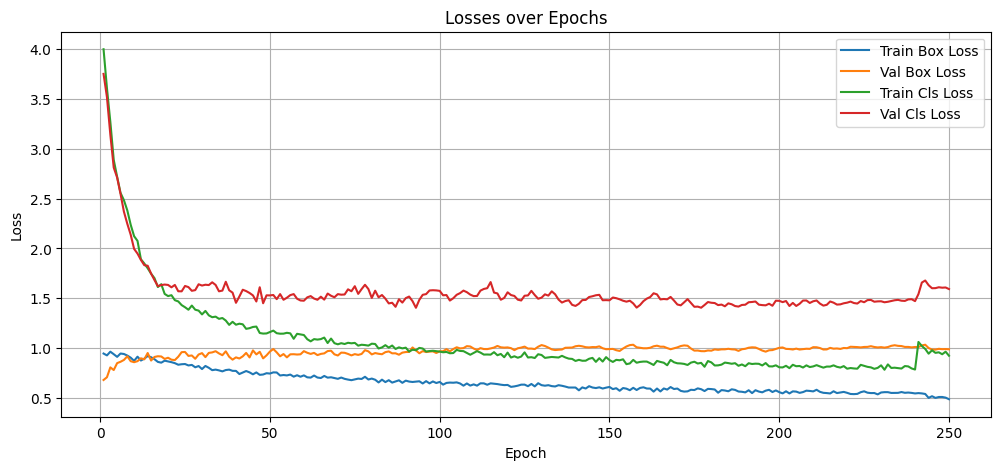

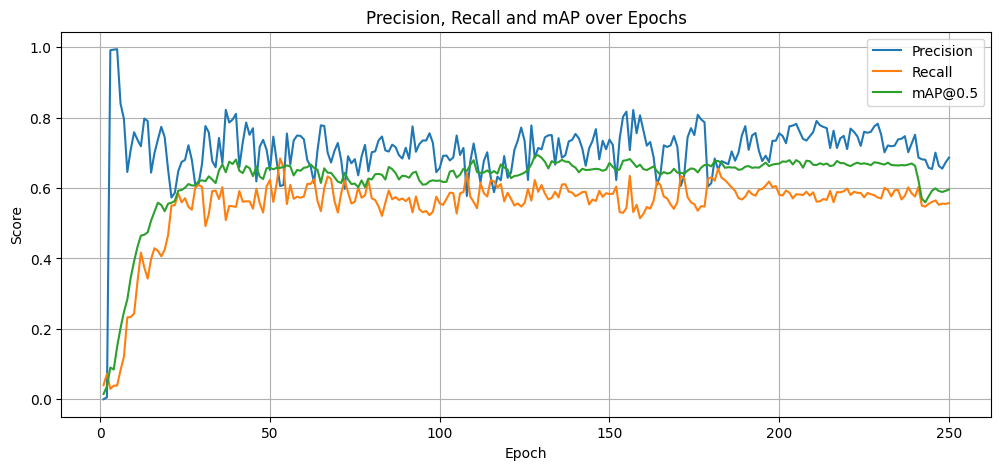

Final Precision: 0.6865
Final Recall: 0.5576
Final mAP50: 0.5958


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/runs/detect/train/results.csv')

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.title('Precision, Recall and mAP over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"Final Precision: {df['metrics/precision(B)'].iloc[-1]:.4f}")
print(f"Final Recall: {df['metrics/recall(B)'].iloc[-1]:.4f}")
print(f"Final mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")


Saving 2008_000070.jpg to 2008_000070 (1).jpg

image 1/1 /content/2008_000070.jpg: 480x640 2 chairs, 1 tvmonitor, 44.2ms
Speed: 3.0ms preprocess, 44.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


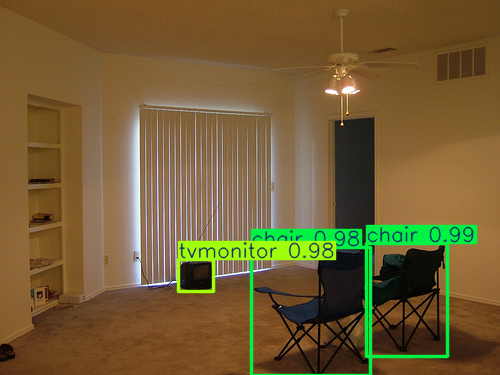

In [13]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train/weights/best.pt")

image_path = "2008_000070.jpg"

results = model(image_path)

results[0].show()